**Chapter 6: Enhancing and Segmenting Images**
# Denoising with Auto-Encoders

Reusing the simple fully-connected auto-encoder implemented in the previous notebook, we will now demonstrate how such network can be used to **recover corrupted/noisy images**.

In [1]:
import tensorflow as tf

## Preparing the Dataset

Exactly like before, we prepare [MNIST](http://yann.lecun.com/exdb/mnist), the dataset chosen for this simple experiment[$^1$](#ref):

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_height, img_width = x_train.shape[1:]
img_channels = 1

# For the following experiments, we will however not use the class labels:
del y_train
del y_test

# Normalizing the image data:
x_train, x_test = x_train / 255.0, x_test / 255.0

# Even though we will use again a basic fully-coonected network, we need to preserve the image format
# of the sample this time, to use the Keras image pre-processing tool to add noise. Therefore, 
# the augmented images will be flattened by the network itself via a initial Flatten() layer.
x_train = x_train.reshape((-1, img_height, img_width, img_channels))
x_test = x_test.reshape((-1, img_height, img_width, img_channels))

print("Shape of training set: {}".format(x_train.shape))
print("Shape of testing set: {}".format(x_test.shape))

# Setting some variables:
batch_size = 64
train_steps_per_epoch = len(x_train) // batch_size
val_steps_per_epoch = len(x_test) // batch_size

Shape of training set: (60000, 28, 28, 1)
Shape of testing set: (10000, 28, 28, 1)


## Building an Auto-Encoder for Image Denoising

As mentioned in the book, denoising auto-encoders are normal auto-encoders, but **fed with corrupted samples** while still trying to recover the original images. Therefore, we need to instantiate our network, and build a method to corrupt our images.

### Simple auto-encoder

For this experiment, we will reuse the exact same architecture as in the previous notebook:

In [3]:
code_size = 32

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape

inputs = Input(shape=[img_height, img_width, img_channels], name='input')

# As previously mentioned, the image flattening is done here:
inputs_flat = Flatten()(inputs)

# Encoding layers:
enc_1 = Dense(128, activation='relu', name='enc_dense1')(inputs_flat)
enc_2 = Dense(64, activation='relu', name='enc_dense2')(enc_1)
code = Dense(code_size, activation='relu', name='enc_dense3')(enc_2)

# Decoding layers:
dec_1 = Dense(64, activation='relu', name='dec_dense1')(code)
dec_2 = Dense(128, activation='relu', name='dec_dense2')(dec_1)
decoded = Dense(img_height * img_width, activation='sigmoid', name='dec_dense3')(dec_2)
# note: we use a sigmoid for the last activation, as we want the output values
# to be between 0 and 1, like the input ones.

# Finally, we reshape the decoded data so it has the same shape as the input samples:
decoded_reshape = Reshape([img_height, img_width, img_channels])(decoded)

# Auto-encoder model:
autoencoder = Model(inputs, decoded_reshape)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
enc_dense1 (Dense)           (None, 128)               100480    
_________________________________________________________________
enc_dense2 (Dense)           (None, 64)                8256      
_________________________________________________________________
enc_dense3 (Dense)           (None, 32)                2080      
_________________________________________________________________
dec_dense1 (Dense)           (None, 64)                2112      
_________________________________________________________________
dec_dense2 (Dense)           (None, 128)               8320      
__________

### Generator of noisy images

We now set up our input pipeline, adding a pre-processing step to corrupt our images. We will use this simple function for that:

In [5]:
import numpy as np

def add_noise(img, min_noise_factor=.3, max_noise_factor=.6):
    """
    Add some random noise to an image, from a uniform distribution.
    :param img:               Image to corrupt
    :param min_noise_factor:  Min. value for the noise random average amplitude
    :param max_noise_factor:  Max. value for the noise random average amplitude
    :return:                  Corrupted image
    """
    # Generating and applying noise to image:
    noise_factor = np.random.uniform(min_noise_factor, max_noise_factor)
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=img.shape) 
    img_noisy = img + noise
    
    # Making sure the image value are still in the proper range:
    img_noisy = np.clip(img_noisy, 0., 1.)
    
    return img_noisy

Let us have a look how this affects our images. To visualize some results, we first implement the following method to draw grids of results. This will come handy later.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def plot_image_grid(images, titles=None, figure=None,
                    grayscale=False, transpose=False):
    """
    Plot a grid of n x m images.
    :param images:       Images in a n x m array
    :param titles:       (opt.) List of m titles for each image column
    :param figure:       (opt.) Pyplot figure (if None, will be created)
    :param grayscale:    (opt.) Flag to draw the images in grayscale
    :param transpose:    (opt.) Flag to transpose the grid
    :return:             Pyplot figure filled with the images
    """
    num_cols, num_rows = len(images), len(images[0])
    img_ratio = images[0][0].shape[1] / images[0][0].shape[0]

    if transpose:
        vert_grid_shape, hori_grid_shape = (1, num_rows), (num_cols, 1)
        figsize = (int(num_rows * 5 * img_ratio), num_cols * 5)
        wspace, hspace = 0.2, 0.
    else:
        vert_grid_shape, hori_grid_shape = (num_rows, 1), (1, num_cols)
        figsize = (int(num_cols * 5 * img_ratio), num_rows * 5)
        hspace, wspace = 0.2, 0.

    if figure is None:
        figure = plt.figure(figsize=figsize)
    imshow_params = {'cmap': plt.get_cmap('gray')} if grayscale else {}
    grid_spec = gridspec.GridSpec(*hori_grid_shape, wspace=0, hspace=0)

    for j in range(num_cols):
        grid_spec_j = gridspec.GridSpecFromSubplotSpec(
            *vert_grid_shape, subplot_spec=grid_spec[j], wspace=wspace, hspace=hspace)

        for i in range(num_rows):
            ax_img = figure.add_subplot(grid_spec_j[i])
            # ax_img.axis('off')
            ax_img.set_yticks([])
            ax_img.set_xticks([])
            if titles is not None:
                if transpose:
                    ax_img.set_ylabel(titles[j], fontsize=25)
                else:
                    ax_img.set_title(titles[j], fontsize=15)
            ax_img.imshow(images[j][i], **imshow_params)

    figure.tight_layout()
    return figure

**Note:** We will save this method in [plot_utils.py](./plot_utils.py) and use it in the next notebooks.

/home/benjamin/anaconda3/envs/main/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


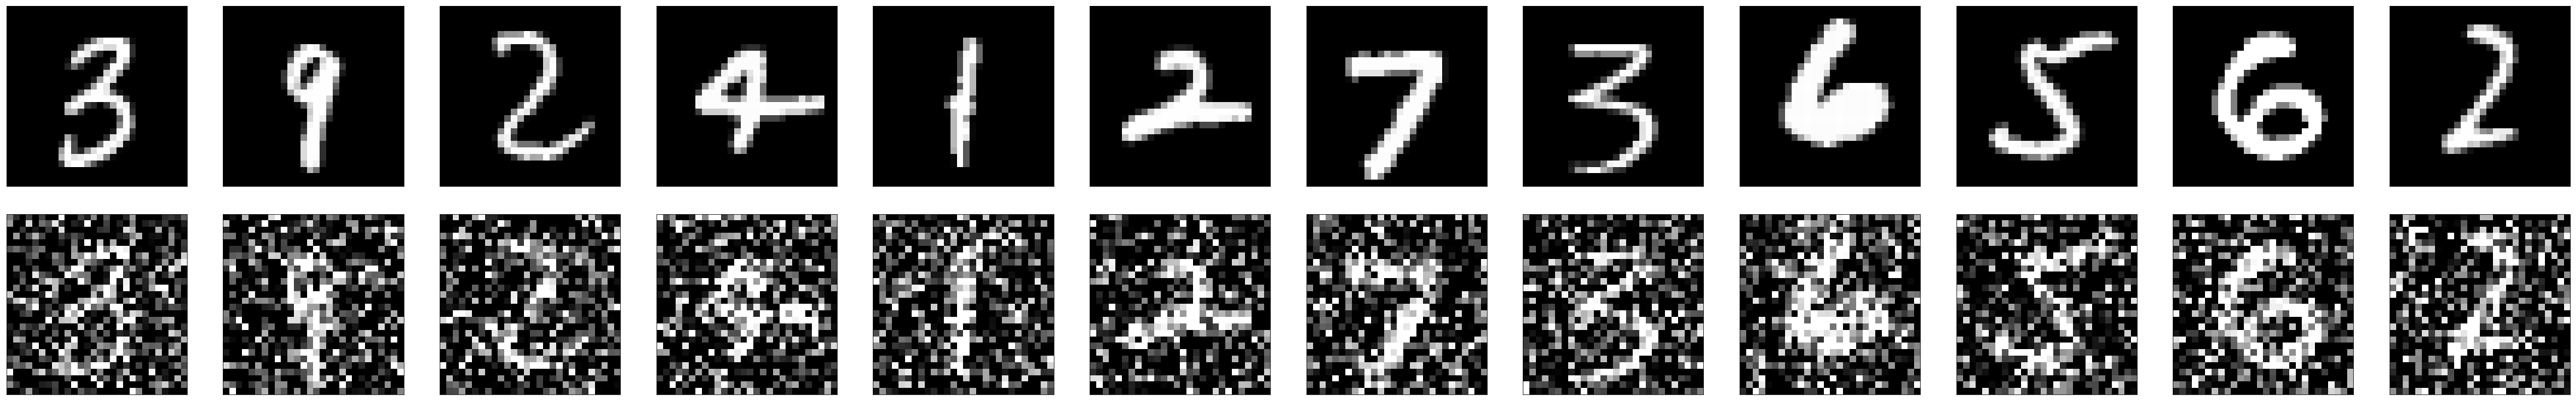

In [7]:
num_show = 12
random_image_indices = np.random.choice(len(x_test), size=num_show)

orig_samples = x_test[random_image_indices]
noisy_samples = add_noise(orig_samples)

fig = plot_image_grid([np.squeeze(orig_samples), np.squeeze(noisy_samples)],
                      grayscale=True, transpose=True)
fig.show()

Our corrupting function is doing its job, adding some _salt-and-pepper_ noise. Some digits are even hard to recognize... Let us see how our denoising model will manage...

We now have a choice. We could simply apply our noise function to the whole training set (`x_noisy = add_noise(x_train)`) and pass it to our model for training (`autoencoder.fit(x_noisy, x_train)`). While straightforward, this solution has one inconvenient: each original image have only one noisy version. Epoch after epoch, the network will receive the same noisy images. There is thus a risk that it may overfit some of the data.

Another solution would be to corrupt each batch of images at each iteration, thus creating different corrupted versions each time. While a bit heavier, this solution provides our network with new samples each time, making it more robust. We will therefore opt for this solution.

To implement it, we will use a _**generator**_, a Python object yielding new elements each time it is called. Keras models can be trained directly on datasets (`model.fit(...)`), or on generators (`model.fit_generator(...)`). Though less advanced that TensorFlow `tf.data.Dataset`, generators share some common advantages (e.g., for datasets too big to be loaded at once, a generator can be used to load only the images for the next batches).

Keras offers several pre-implemented generators, to iterate over image folders, image arrays, etc. Here, we will use `ImageDataGenerator`, which can iterate over numpy arrays to generate batches. This generator can also be configured to pre-process each batch before yielding it. This is exactly what we need:

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# We define our Keras generator, passing our noisy function as pre-processing step:
train_datagen = ImageDataGenerator(preprocessing_function=add_noise)

# Then we pass our dataset to the generator and specify how the yielded batch should be
# (batch size, shuffling or not, etc.).
train_generator = train_datagen.flow(x_train, x_train, 
                                     batch_size=batch_size, shuffle=True)
train_generator

Our input pipeline is ready, though we need to prepare the validation data too.

To be able to consistently compare metrics from one epoch to another, we augment the validation images with noise only once, and saved the resulting images so they can be reused for each epoch:

In [9]:
x_test_noisy = add_noise(x_test)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
val_generator = train_datagen.flow(x_test_noisy, x_test,
                                   batch_size=batch_size, shuffle=False)

## Training and Monitoring

As in previous experiments, we will set up some monitoring tools, then train our model.

### PSNR as custom metric

We reuse PSNR, to evaluate how well our model recovered the corrupted sampled, compared to the original ones:

In [10]:
import functools

psnr_metric = functools.partial(tf.image.psnr, max_val=1.)
psnr_metric.__name__ = 'psnr'

### Custom callback to plot result grids

To keep experimenting with Keras and TensorFlow, we will implement another **custom callback**. Instead of waiting the end of the training to visualize some predicted images, would it be not better to **plot some result grids after each epoch** for instance? Even better: we could reuse the same input/target images each time, so we can compare the predicted versions from one epoch to another!

The following custom callback does exactly that. At the end of each epoch, it feeds the model with some pre-selected images, then use `matplotlib` to draw a result grid. It then converts the `pyplot.Figure` into a `tensorflow.Summary` which can be saved by TensorFlow an read by Tensorboard for display (image summaries can be seen in [http://localhost:6006/#images](http://localhost:6006/#images) once Tensorboard started.

This is what will appear in Tensorboard (with the slider to visualize other steps/epochs):

![Tensorboard screenshot](./notebook_images/tensorboard_result_grid.png)

In [11]:
import io

def figure_to_rgb_array(fig):
    """
    Convert figure into a RGB array
    :param fig:         PyPlot Figure
    :return:            RGB array
    """
    figure_buffer = io.BytesIO()
    fig.savefig(figure_buffer, format='png')
    figure_buffer.seek(0)
    figure_string = figure_buffer.getvalue()
    return figure_string


def figure_to_summary(fig, tag):
    """
    Convert figure into TF summary
    :param fig:             Figure
    :param tag:             Summary tag
    :return:                Summary
    """
    # Transform figure into PNG buffer:
    figure_string = figure_to_rgb_array(fig)
    
    # figure_tensor = tf.image.decode_png(figure_string, channels=4)
    # figure_tensor = tf.expand_dims(figure_tensor, 0) # adding batch dimension
    
    # Using Proto to convert the image string into a summary:
    figure_summary_image = tf.Summary.Image(
        # height=input_images.shape[1], width=input_images.shape[2],
        # colorspace=4, 
        encoded_image_string=figure_string) 
    figure_summary = tf.Summary(
        value=[tf.Summary.Value(tag=tag, image=figure_summary_image)])
    
    return figure_summary


class TensorBoardImageGridCallback(tf.keras.callbacks.Callback):
    """ Keras callback for generative models, to draw grids of 
        input/predicted/target images into Tensorboard every epoch.
    """
    def __init__(self, log_dir, input_images, target_images=None, tag='images',
                 figsize=(10, 10), dpi=300, grayscale=False, transpose=False,
                 preprocess_fn=None):
        """
        Initialize the Callback.
        :param log_dir:         Folder to write the image summaries into
        :param input_images:    List of input images to use for the grid
        :param target_images:   (opt.) List of target images for the grid
        :param tag:             Tag to name the Tensorboard summary
        :param figsize:         Pyplot figure size for the grid
        :param dpi:             Pyplot figure DPI
        :param grayscale:       Flag to plot the images as grayscale
        :param transpose:       Flag to transpose the image grid
        :param preprocess_fn:   (opt.) Function to pre-process the 
                                input/predicted/target image lists before plotting
        """
        super().__init__()
        
        self.summary_writer = tf.summary.FileWriter(log_dir)
        
        self.input_images, self.target_images = input_images, target_images
        self.tag = tag
        self.postprocess_fn = preprocess_fn
        
        self.image_titles = ['images', 'predicted']
        if self.target_images is not None:
            self.image_titles.append('ground-truth')
        
        # Initializing the figure:
        self.fig = plt.figure(num=0, figsize=figsize, dpi=dpi)
        self.grayscale = grayscale
        self.transpose = transpose

    def on_epoch_end(self, epoch, logs={}):
        """
        Plot into Tensorboard a grid of image results.
        :param epoch:   Epoch num
        :param logs:    (unused) Dictionary of loss/metrics value for the epoch
        """
        
        # Get predictions with current model:
        predicted_images = self.model.predict_on_batch(self.input_images)
        if self.postprocess_fn is not None:
            input_images, predicted_images, target_images = self.postprocess_fn(
                self.input_images, predicted_images, self.target_images)
        else:
            input_images, target_images = self.input_images, self.target_images
        
        # Fill figure with images:
        grid_imgs = [input_images, predicted_images]
        if target_images is not None:
            grid_imgs.append(target_images)
        self.fig.clf()
        self.fig = plot_image_grid(grid_imgs, titles=self.image_titles, figure=self.fig,
                                   grayscale=self.grayscale, transpose=self.transpose)
        
        # Transform into summary:
        figure_summary = figure_to_summary(self.fig, self.tag)
        
        # Finally, log it:
        self.summary_writer.add_summary(figure_summary, global_step=epoch)
    
    def on_train_end(self, logs={}):
        """
        Close the resources used to plot the grids.
        :param logs:    (unused) Dictionary of loss/metrics value for the epoch
        """
        self.summary_writer.close()
        plt.close(self.fig)

### Custom callback for simple logs

Additionally, we will define another custom callback, to replace the default callback called by Keras to log results in the console, when `model.fit(..., verbose=1)`.

We will define a much simpler logging function, which will just display results at the end of each epoch (and not the progress bar), in order to condense a bit the logs (and make the notebooks more readable):

In [12]:
# Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
log_template = 'Epoch {0:2}/{1} - loss = {2:5.3f}; val-loss = {3:5.3f}; psnr = {4:5.3f}; val-psnr = {5:5.3f}'
callback_simple_log = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(
        log_template.format(epoch, num_epochs, 
                            logs['loss'], logs['val_loss'], logs['psnr'], logs['val_psnr'])))

**Note:** A more advanced version of this custom callback (with prettier logs...), as well as `TensorBoardImageGridCallback`, can be found in [./keras_custom_callbacks.py](./keras_custom_callbacks.py). We will import this script in future notebooks to reuse these callbacks.

### Training and results

It is now just a matter of launching the training, and monitoring it here or in Tensorboard:

In [15]:
model_dir  = './models/ae_denoising_mnist'
num_epochs = 50

callbacks  = [
    # Callback to interrupt the training if the validation loss stops improving:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to print compacted metrics at the end of each epoch:
    callback_simple_log,
    # Callback to log some validation results as image grids into TensorBoard:
    TensorBoardImageGridCallback(
        log_dir=model_dir, input_images=noisy_samples, target_images=orig_samples, 
        tag='ae_results', figsize=(len(noisy_samples) * 3, 3 * 3), 
        grayscale=True, transpose=True,
        preprocess_fn=lambda img, pred, gt: (
            # Squeezing the images from H x W x 1 to H x W, otherwise Pyplot complains:
            np.squeeze(img, -1), np.squeeze(pred, -1), np.squeeze(gt, -1)))
]

autoencoder.compile(optimizer='adam', loss='binary_crossentropy',
                    metrics=[psnr_metric])

# `model.fit_generator()` works quite similarly to `model.fit()` 
# used with tf.data inputs (c.f. notebooks for Chapter 4).
# In other words, we need to specify the number of batches ("steps") per epoch, 
# for Keras to keep track.
print('Training: start')
history = autoencoder.fit_generator(
    train_generator, steps_per_epoch=train_steps_per_epoch, epochs=num_epochs,
    validation_data=val_generator, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)
print('Training: end')

Training: start
Epoch  0/50 - loss = 7.805; val-loss = 9.658; psnr = 17.596; val-psnr = 15.769
Epoch  1/50 - loss = 7.706; val-loss = 9.613; psnr = 17.714; val-psnr = 15.774
Epoch  2/50 - loss = 7.618; val-loss = 9.516; psnr = 17.813; val-psnr = 15.890
Epoch  3/50 - loss = 7.554; val-loss = 9.448; psnr = 17.893; val-psnr = 15.900
Epoch  4/50 - loss = 7.489; val-loss = 9.480; psnr = 17.971; val-psnr = 15.896
Epoch  5/50 - loss = 7.445; val-loss = 9.352; psnr = 18.027; val-psnr = 16.021
Epoch  6/50 - loss = 7.401; val-loss = 9.292; psnr = 18.084; val-psnr = 16.070
Epoch  7/50 - loss = 7.356; val-loss = 9.257; psnr = 18.140; val-psnr = 16.082
Epoch  8/50 - loss = 7.320; val-loss = 9.210; psnr = 18.191; val-psnr = 16.128
Epoch  9/50 - loss = 7.287; val-loss = 9.260; psnr = 18.232; val-psnr = 16.107
Epoch 10/50 - loss = 7.256; val-loss = 9.274; psnr = 18.274; val-psnr = 16.124
Epoch 11/50 - loss = 7.225; val-loss = 9.161; psnr = 18.313; val-psnr = 16.197
Epoch 12/50 - loss = 7.201; val-loss

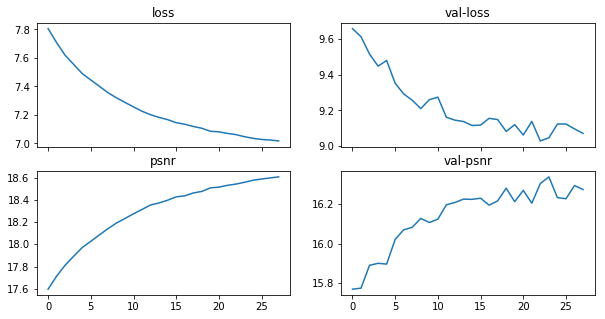

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("psnr")
ax[1, 1].set_title("val-psnr")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['psnr'])
ax[1, 1].plot(history.history['val_psnr'])

Though we already have results drawn in Tensorboard, let us add one last image grid to this notebook:

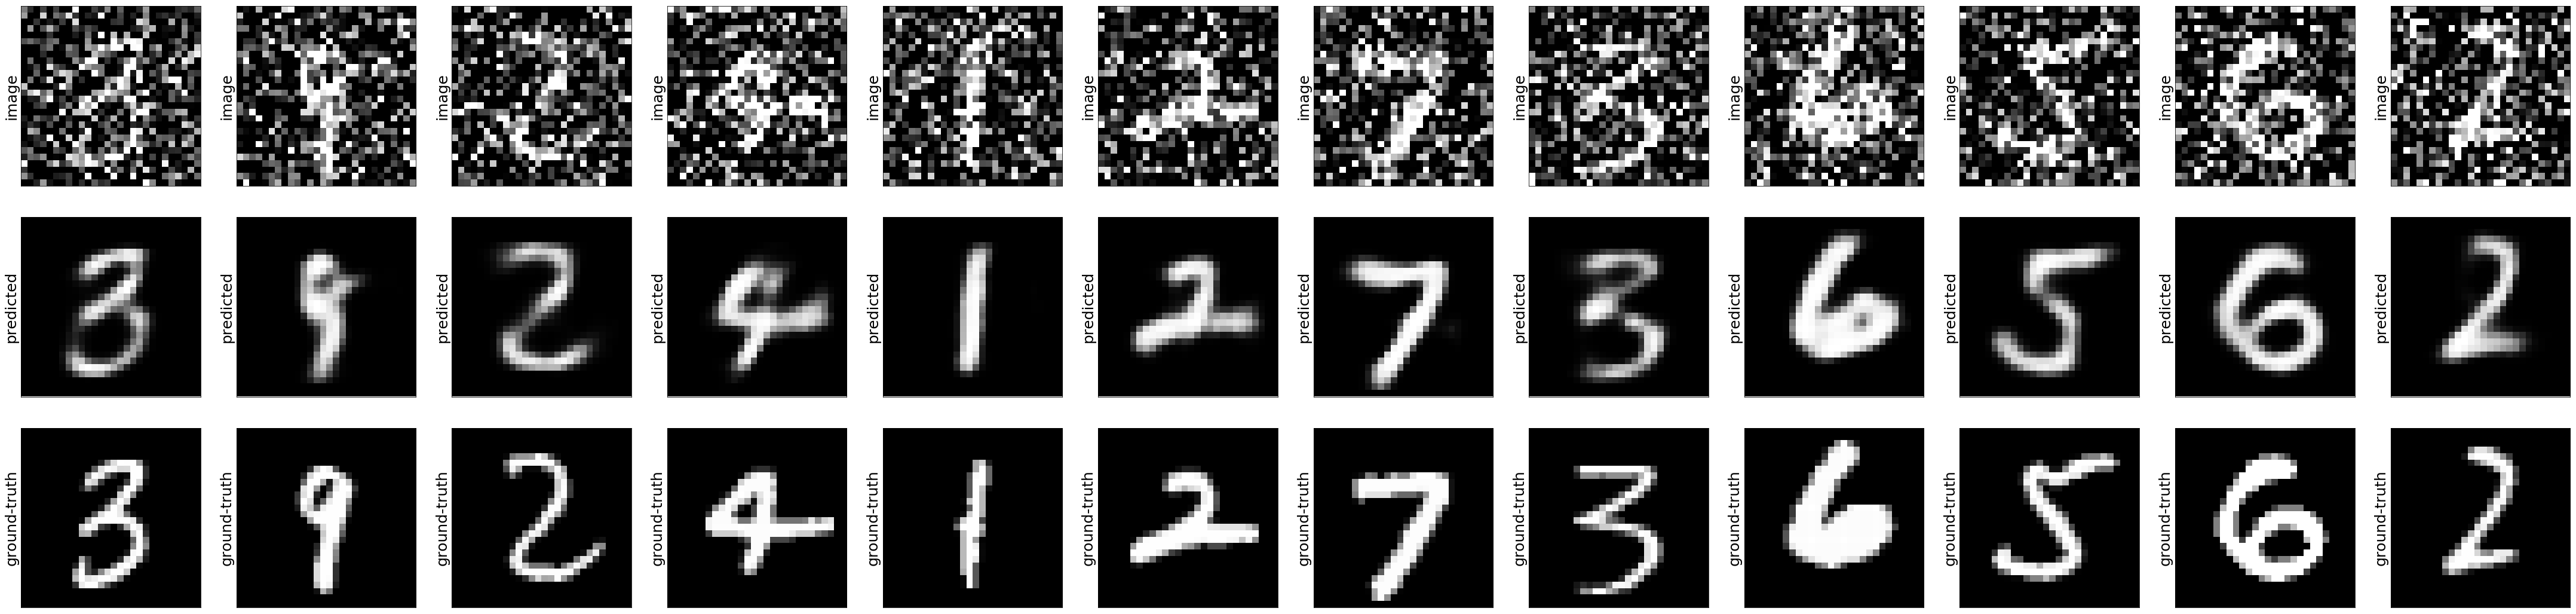

In [17]:
predicted_samples = autoencoder.predict_on_batch(noisy_samples)

fig = plot_image_grid([np.squeeze(noisy_samples),
                       np.squeeze(predicted_samples),
                       np.squeeze(orig_samples)],
                      titles=['image', 'predicted', 'ground-truth'],
                      grayscale=True, transpose=True)
fig.show()

## Conclusion

As we can see, though the denoising is not perfect and information is sometimes lost, our simplistic auto-encoder is doing rather well. In the next notebook, we will implement a more advanced, convolutional network for the more complex problem of image super-resolution.

<a id="ref"></a>
#### References

1. LeCun, Y., Cortes, C., Burges, C., 2010. MNIST handwritten digit database. AT&T Labs [Online]. Available: http://yann.lecun.com/exdb/mnist 2, 18.